<a href="https://colab.research.google.com/github/hafsahhannah/COVID-19-Prediction-using-LSTM-Model/blob/main/covid_19_case_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#%% Import packages

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.impute import KNNImputer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import datetime

In [ ]:
#%% Data loading

TRAIN_DATASET = os.path.join(os.getcwd(), 'cases_malaysia_train.csv')
TEST_DATASET = os.path.join(os.getcwd(), 'cases_malaysia_test.csv')

train_df = pd.read_csv(TRAIN_DATASET)
test_df = pd.read_csv(TEST_DATASET)

In [ ]:
#%% Data inspection

train_df.head(5)   # to show n rows of data
train_df.tail(5)   # to show n rows of data

,date,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_unvax,cases_pvax,cases_fvax,cases_boost,...,cases_60_69,cases_70_79,cases_80,cluster_import,cluster_religious,cluster_community,cluster_highRisk,cluster_education,cluster_detentionCentre,cluster_workplace
675,30/11/2021,4879,24,5168,64978,97,1125,55,3595,104,...,358,165,60,0.0,25.0,0.0,28.0,33.0,0.0,31.0
676,1/12/2021,5439,21,6803,63583,110,1363,54,3900,122,...,387,197,61,0.0,25.0,0.0,8.0,33.0,0.0,31.0
677,2/12/2021,5806,11,7246,62099,339,1325,40,4271,170,...,410,174,59,0.0,14.0,2.0,13.0,148.0,52.0,110.0
678,3/12/2021,5551,23,5301,62303,179,1312,46,4046,147,...,411,167,48,0.0,6.0,0.0,3.0,104.0,0.0,66.0
679,4/12/2021,4896,18,4676,62481,159,1143,56,3529,168,...,327,158,52,0.0,3.0,1.0,22.0,52.0,0.0,81.0


In [ ]:
train_df.info()     # cases_new is in object (Need to be converted into int/float)
train_df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     680 non-null    object 
 1   cases_new                680 non-null    object 
 2   cases_import             680 non-null    int64  
 3   cases_recovered          680 non-null    int64  
 4   cases_active             680 non-null    int64  
 5   cases_cluster            680 non-null    int64  
 6   cases_unvax              680 non-null    int64  
 7   cases_pvax               680 non-null    int64  
 8   cases_fvax               680 non-null    int64  
 9   cases_boost              680 non-null    int64  
 10  cases_child              680 non-null    int64  
 11  cases_adolescent         680 non-null    int64  
 12  cases_adult              680 non-null    int64  
 13  cases_elderly            680 non-null    int64  
 14  cases_0_4                6

,count,mean,std,min,25%,50%,75%,max
cases_import,680.0,8.788235,9.162540,0.0,3.00,6.0,12.00,72.0
cases_recovered,680.0,3766.514706,5622.296192,0.0,46.50,1201.5,5173.50,24855.0
cases_active,680.0,45733.016176,67888.984001,1.0,1158.25,14371.0,64899.25,263845.0
cases_cluster,680.0,717.130882,827.327827,0.0,13.00,417.5,1117.75,3394.0
cases_unvax,680.0,2452.023529,3191.392812,0.0,46.50,1257.5,3462.50,12684.0
cases_pvax,680.0,578.805882,1532.323940,0.0,0.00,0.0,118.25,7313.0
cases_fvax,680.0,868.045588,1877.386774,0.0,0.00,0.0,116.50,8456.0
cases_boost,680.0,4.763235,21.433285,0.0,0.00,0.0,0.00,170.0
cases_child,680.0,519.935294,831.685231,0.0,2.00,109.0,754.25,3437.0
cases_adolescent,680.0,261.016176,433.549560,0.0,2.00,63.0,304.00,1820.0


In [ ]:
train_df.duplicated().sum() #No duplicated data found
train_df.isnull().mean()

date                       0.000000
cases_new                  0.000000
cases_import               0.000000
cases_recovered            0.000000
cases_active               0.000000
cases_cluster              0.000000
cases_unvax                0.000000
cases_pvax                 0.000000
cases_fvax                 0.000000
cases_boost                0.000000
cases_child                0.000000
cases_adolescent           0.000000
cases_adult                0.000000
cases_elderly              0.000000
cases_0_4                  0.000000
cases_5_11                 0.000000
cases_12_17                0.000000
cases_18_29                0.000000
cases_30_39                0.000000
cases_40_49                0.000000
cases_50_59                0.000000
cases_60_69                0.000000
cases_70_79                0.000000
cases_80                   0.000000
cluster_import             0.502941
cluster_religious          0.502941
cluster_community          0.502941
cluster_highRisk           0

In [ ]:
#%% Data cleaning

# Change data types
train_df['cases_new'] = train_df['cases_new'].str.replace(r'[^0-9a-zA-Z:,]+', '')
train_df['cases_new'] = train_df['cases_new'].replace(r'^\s*$', np.NaN, regex=True)
train_df['cases_new'] = train_df['cases_new'].astype('float')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 680 entries, 0 to 679
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   date                     680 non-null    object 
 1   cases_new                668 non-null    float64
 2   cases_import             680 non-null    int64  
 3   cases_recovered          680 non-null    int64  
 4   cases_active             680 non-null    int64  
 5   cases_cluster            680 non-null    int64  
 6   cases_unvax              680 non-null    int64  
 7   cases_pvax               680 non-null    int64  
 8   cases_fvax               680 non-null    int64  
 9   cases_boost              680 non-null    int64  
 10  cases_child              680 non-null    int64  
 11  cases_adolescent         680 non-null    int64  
 12  cases_adult              680 non-null    int64  
 13  cases_elderly            680 non-null    int64  
 14  cases_0_4                6

<ipython-input-6-2be206a0850e>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  train_df['cases_new'] = train_df['cases_new'].str.replace(r'[^0-9a-zA-Z:,]+', '')


In [ ]:
# Clean test_df

test_df['cases_new'] = test_df['cases_new'].replace(r'[^0-9a-zA-Z:,]+', '')
test_df['cases_new'] = test_df['cases_new'].replace(r'^\s*$', np.NaN, regex=True)

In [ ]:
print(train_df['cases_new'].isnull().sum())

12


In [ ]:
# Deal with the null values

train_df['cases_new'] = train_df['cases_new'].fillna(0)
train_df['cases_new'] = train_df['cases_new'].interpolate(method='polynomial', order=2)
test_df['cases_new'] = test_df['cases_new'].fillna(0)

In [ ]:
print(train_df.isna().sum()) # Checking if the null values are still there

date                         0
cases_new                    0
cases_import                 0
cases_recovered              0
cases_active                 0
cases_cluster                0
cases_unvax                  0
cases_pvax                   0
cases_fvax                   0
cases_boost                  0
cases_child                  0
cases_adolescent             0
cases_adult                  0
cases_elderly                0
cases_0_4                    0
cases_5_11                   0
cases_12_17                  0
cases_18_29                  0
cases_30_39                  0
cases_40_49                  0
cases_50_59                  0
cases_60_69                  0
cases_70_79                  0
cases_80                     0
cluster_import             342
cluster_religious          342
cluster_community          342
cluster_highRisk           342
cluster_education          342
cluster_detentionCentre    342
cluster_workplace          342
dtype: int64


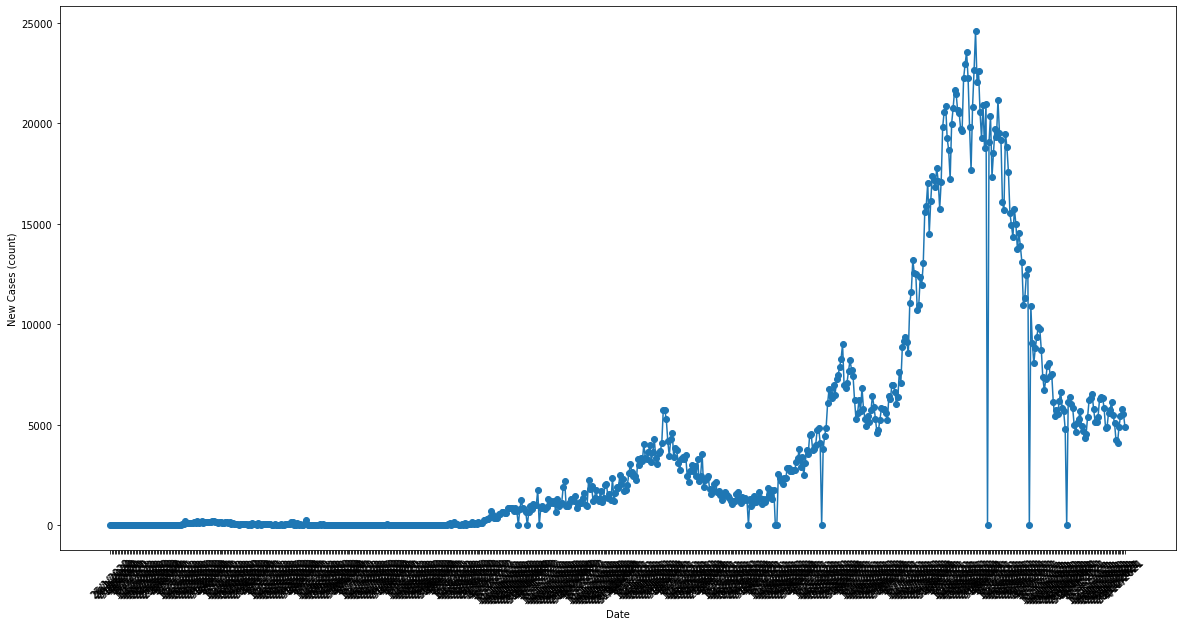

In [ ]:
# Plot new cases

plt.figure(figsize=(20,10))
plt.plot(train_df['date'], train_df['cases_new'], marker='o')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('New Cases (count)')
plt.show()


In [ ]:
#%% Features Selection

train_df['cases_new'].dtypes

train_df = train_df['cases_new'].values

mms = MinMaxScaler()
train_df_scaled = mms.fit_transform(np.expand_dims(train_df, axis=-1)) # Expand dims

In [ ]:
X_train = []
y_train = []

win_size = 30
for i in range(win_size,len(train_df_scaled)):
    X_train.append(train_df_scaled[i-win_size:i])
    y_train.append(train_df_scaled[i])
X_train = np.array(X_train)
y_train = np.array(y_train)

In [ ]:
#%% Model development

def LSTM_model():
    
    model = Sequential()
    
    model.add(LSTM(units = 64, return_sequences = True, input_shape=(X_train.shape[1:])))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 64, return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 64))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=1))
    
    return model

In [ ]:
#%% Model Training

model = LSTM_model()
model.summary()
model.compile(optimizer='adam',loss='mse',metrics=['mse','mape'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 64)            16896     
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 6

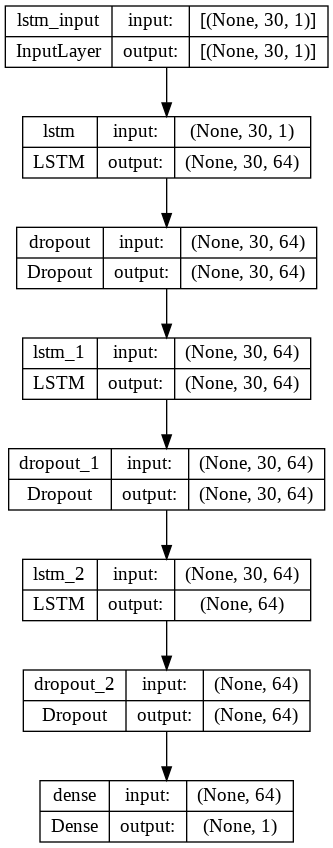

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
# Tensorboard callback 
%load_ext tensorboard

LOGS_PATH = os.path.join(os.getcwd(),'logs',datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))
ts_callback = TensorBoard(log_dir=LOGS_PATH)
es_callback = EarlyStopping(monitor='val_loss',patience=5,verbose=0,restore_best_weights=True)


In [ ]:
X_train, X_test, y_train,y_test = train_test_split(X_train,y_train,test_size=0.2,shuffle=True,random_state=123)

In [ ]:
# Fitting our model

hist = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10, batch_size=64,callbacks=[es_callback,ts_callback])

Epoch 1/10
9/9 [==============================] - 12s 264ms/step - loss: 0.0396 - mse: 0.0396 - mape: 4854167.5000 - val_loss: 0.0109 - val_mse: 0.0109 - val_mape: 3685764.2500
Epoch 2/10
9/9 [==============================] - 1s 85ms/step - loss: 0.0111 - mse: 0.0111 - mape: 3233537.5000 - val_loss: 0.0051 - val_mse: 0.0051 - val_mape: 2345450.5000
Epoch 3/10
9/9 [==============================] - 1s 83ms/step - loss: 0.0099 - mse: 0.0099 - mape: 3717006.2500 - val_loss: 0.0087 - val_mse: 0.0087 - val_mape: 1914662.8750
Epoch 4/10
9/9 [==============================] - 1s 82ms/step - loss: 0.0082 - mse: 0.0082 - mape: 2886195.2500 - val_loss: 0.0050 - val_mse: 0.0050 - val_mape: 2937104.7500
Epoch 5/10
9/9 [==============================] - 1s 81ms/step - loss: 0.0066 - mse: 0.0066 - mape: 4239607.5000 - val_loss: 0.0041 - val_mse: 0.0041 - val_mape: 2474927.0000
Epoch 6/10
9/9 [==============================] - 1s 86ms/step - loss: 0.0063 - mse: 0.0063 - mape: 3404669.2500 - val_loss

In [ ]:
print(hist.history.keys())

dict_keys(['loss', 'mse', 'mape', 'val_loss', 'val_mse', 'val_mape'])


In [ ]:
%tensorboard --logdir logs

<IPython.core.display.Javascript object>

In [ ]:
test_df = test_df ['cases_new'].values
test_df_scaled = mms.transform(test_df[::,None])

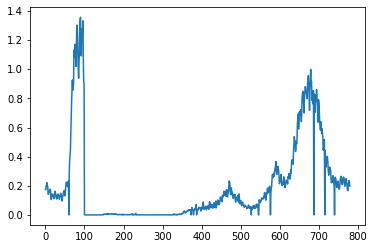

In [ ]:
# Concat both train data and test data

concatenated = np.concatenate((test_df_scaled,train_df_scaled))

plt.figure()
plt.plot(concatenated)
plt.show()



In [ ]:
X_testtest = []
y_testtest = []

for i in range(win_size, len(test_df)):
    X_testtest.append(concatenated[i-win_size:i])
    y_testtest.append(concatenated[i])

X_testtest = np.array(X_testtest)
y_testtest = np.array(y_testtest)

In [ ]:
#%% Model deployment
predicted = model.predict(X_testtest)

3/3 [==============================] - 1s 15ms/step


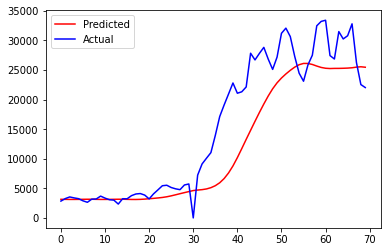

In [ ]:
# Inversing the normalize predicted 

inversed_cases = mms.inverse_transform(predicted)
inversed_actual_cases = mms.inverse_transform(y_testtest)

plt.figure()
plt.plot(inversed_cases,color='red')
plt.plot(inversed_actual_cases,color='blue')
plt.legend(['Predicted','Actual'])
plt.show()

In [ ]:
# Based on the data, what's the prediction for tomorrow?

print(f'Prediction of tomorrow is {int(inversed_cases[-1, 0])}') 

Prediction of tomorrow is 25464


In [ ]:
print(mean_absolute_error(inversed_actual_cases,inversed_cases)/sum(abs(inversed_actual_cases))*100)


[0.36502967]


In [ ]:
#%% Model evaluation using metrics
print(mean_squared_error(inversed_actual_cases,inversed_cases))
print(mean_absolute_percentage_error(inversed_actual_cases,inversed_cases))


31417640.004580695
2.975015210263549e+17


In [ ]:
#%% Model deployment
# To save the trained model

model.save('model.h5')
